In [231]:
import pandas as pd
import numpy as np
import progressbar
import math
from tqdm import tqdm
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier as RFC

In [232]:
def to_categorical(x, n_col=None):
    """ One-hot encoding номинального признака """
    if not n_col:
        n_col = int(np.amax(x) + 1)
    one_hot = np.zeros((x.shape[0], n_col))
    one_hot[np.arange(x.shape[0]), x] = 1
    return one_hot

def divide_on_feature(X, feature_i, threshold):
    """ Разделение набора данных по превышению признака feature_i порога"""
    split_func = None
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    X_1 = np.array([sample for sample in X if split_func(sample)])
    X_2 = np.array([sample for sample in X if not split_func(sample)])
    return X_1, X_2

def calculate_entropy(y):
    """ энтропия """
    log2 = lambda x: math.log(x) / math.log(2)
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        entropy += -p * log2(p)
    return entropy

def calculate_variance(X):
    """ дисперсия X """
    mean = np.ones(np.shape(X)) * X.mean(0)
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))
    
    return variance

class Loss(object):
    def loss(self, y_true, y_pred):
        return NotImplementedError()

    def gradient(self, y, y_pred):
        raise NotImplementedError()

    def acc(self, y, y_pred):
        return 0
    
class SquareLoss(Loss):
    def __init__(self): pass

    def loss(self, y, y_pred):
        return 0.5 * np.power((y - y_pred), 2)

    def gradient(self, y, y_pred):
        return -(y - y_pred)

class CrossEntropy(Loss):
    def __init__(self): pass

    def loss(self, y, p):
        # Избегаем деления на 0
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    def acc(self, y, p):
        y_true = np.argmax(y, axis=1)
        y_pred = np.argmax(y, axis=1)
        return np.mean(y_true == y_pred, axis=0)

    def gradient(self, y, p):
        # Избегаем деления на 0
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - (y / p) + (1 - y) / (1 - p)
    
bar_widgets = [
    'Обучение: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

In [233]:
class DecisionNode():
    """
    Узел или лист дерева

    Параметры:
    -----------
    feature_i: int
        Номер признака, используемого для ветвления.
    threshold: float
        Пороговое значение, с которым мы будем сравнивать значения признака feature_i при определении прогноза.
    value: float
        Предсказанный класс для задачи классификации или предсказанное значение числового признака y для задачи регрессии.
    true_branch: DecisionNode
        Следующий узел в случае превышения порога.
    false_branch: DecisionNode
        Следующий узел в случае недостижения порога.
    """
    def __init__(
        self,
        feature_i:int=None,
        threshold:float=None,
        value:float=None,
        true_branch=None,
        false_branch=None,
    ):
        self.feature_i = feature_i         
        self.threshold = threshold          
        self.value = value                 
        self.true_branch = true_branch      
        self.false_branch = false_branch 


In [234]:
class DecisionTree(object):
    """
    Родительский класс для ClassificationTree.

    Параметры:
    -----------
    min_samples_split: int
        Минимальное количество объектов, необходимое для разбиения при построении дерева.
    min_impurity: float
        Минимальная информативность, необходимая для дальнейшего ветвления при построении дерева.
    max_depth: int
        Максимальная глубина дерева.
    loss: function
        Функция потерь, используемая в градиентном бустинге для вычисления информативности.
    """
    def __init__(
        self, 
        min_samples_split:int=2,
        min_impurity:float=1e-7,
        max_depth:int=float("inf"), 
        loss=None,
    ):
        self.root = None  # Корневой узел
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self._impurity_calculation = None
        self._leaf_value_calculation = None
        self.one_dim = None
        self.loss = loss

    def fit(self, X, y, loss=None):
        """ Построение дерева """
        self.one_dim = len(np.shape(y)) == 1
        self.root = self._build_tree(X, y)
        self.loss=None

    def _build_tree(self, X, y, current_depth=0):
        """ 
        Рекурсивный метод, который строит дерево решений и разбивает X и соответствующий y 
        по признаку, который (на основе информативности) наилучшим образом разделяет данные
        """

        largest_impurity = 0
        best_criteria = None    # номер факторного признака и порог
        best_sets = None        # Подмножества данных

        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        Xy = np.concatenate((X, y), axis=1)

        n_samples, n_features = np.shape(X)

        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:
            # Вычисляем информативность для каждого факторного признака
            for feature_i in tqdm(range(n_features)):
                # ВСЕ значения признака feature_i
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)
                
                # Цикл по всем уникальным значениям feature_i с вычислением информативности
                for threshold in unique_values:
                    # Разделение X и y по критерию X[feature_i] >= threshold
                    Xy1, Xy2 = divide_on_feature(Xy, feature_i, threshold)

                    if len(Xy1) > 0 and len(Xy2) > 0:
                        # Значения y-в двух подмножествах
                        y1 = Xy1[:, n_features:]
                        y2 = Xy2[:, n_features:]

                        # Вычисление информативности
                        impurity = self._impurity_calculation(y, y1, y2)

                        # Если порог привел к повышению информационного выигрыша,
                        # сохраним порогт и номер признака
                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            best_criteria = {"feature_i": feature_i, "threshold": threshold}
                            best_sets = {
                                "leftX": Xy1[:, :n_features],   # X левого поддерева
                                "lefty": Xy1[:, n_features:],   # y левого поддерева
                                "rightX": Xy2[:, :n_features],  # X правого поддерева
                                "righty": Xy2[:, n_features:]   # y правого поддерева
                                }

        if largest_impurity > self.min_impurity:
            # Строим поддеревья
            true_branch = self._build_tree(best_sets["leftX"], best_sets["lefty"], current_depth + 1)
            false_branch = self._build_tree(best_sets["rightX"], best_sets["righty"], current_depth + 1)
            return DecisionNode(
                feature_i=best_criteria["feature_i"],
                threshold=best_criteria["threshold"], 
                true_branch=true_branch, 
                false_branch=false_branch,
            )

        # Определение значения в листе
        leaf_value = self._leaf_value_calculation(y)

        return DecisionNode(value=leaf_value)


    def predict_value(self, x, tree=None):
        """ Рекурсивный поиск вниз по дереву с построением прогноза по значению итогового листа"""

        if tree is None:
            tree = self.root

        # Если мы находимся в листе, т.е. есть значение value, возвращаем его как прогноз
        if tree.value is not None:
            return tree.value

        # Выбор факторного признака
        feature_value = x[tree.feature_i]

        # Выбор левого или правого поддерева в зависимости от превышения порога
        branch = tree.false_branch
        if isinstance(feature_value, int) or isinstance(feature_value, float):
            if feature_value >= tree.threshold:
                branch = tree.true_branch
        elif feature_value == tree.threshold:
            branch = tree.true_branch

        # Прогноз на поддереве
        return self.predict_value(x, branch)

    def predict(self, X):
        """ Поэлементная классификация набора данных с возвращением множества прогнозов y"""
        y_pred = [self.predict_value(sample) for sample in X]
        return y_pred

    def print_tree(self, tree=None, indent=" "):
        """ Рекурсивный вывод дерева """
        if not tree:
            tree = self.root

        # Если это лист, выводим значение
        if tree.value is not None:
            print (tree.value)
        # иначе идем вглубь
        else:
            # номер признака и порог
            print ("%s:%s? " % (tree.feature_i, tree.threshold))
            # Сценарий при достижении порога
            print ("%sT->" % (indent), end="")
            self.print_tree(tree.true_branch, indent + indent)
            # Сценарий при недостижении порога
            print ("%sF->" % (indent), end="")
            self.print_tree(tree.false_branch, indent + indent)

In [235]:
class RegressionTree(DecisionTree):
    def _calculate_variance_reduction(self, y, y1, y2):
        var_tot = calculate_variance(y)
        var_1 = calculate_variance(y1)
        var_2 = calculate_variance(y2)
        frac_1 = len(y1) / len(y)
        frac_2 = len(y2) / len(y)

        # Вычисление уменьшения дисперсии
        variance_reduction = var_tot - (frac_1 * var_1 + frac_2 * var_2)

        return sum(variance_reduction)

    def _mean_of_y(self, y):
        value = np.mean(y, axis=0)
        return value if len(value) > 1 else value[0]

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_variance_reduction
        self._leaf_value_calculation = self._mean_of_y
        super(RegressionTree, self).fit(X, y)

class ClassificationTree(DecisionTree):
    def _calculate_information_gain(self, y, y1, y2):
        # Вычисление информационного выигрыша
        p = len(y1) / len(y)
        entropy = calculate_entropy(y)
        info_gain = entropy - p * calculate_entropy(y1) - (1 - p) * calculate_entropy(y2)

        return info_gain

    def _majority_vote(self, y):
        most_common = None
        max_count = 0
        for label in np.unique(y):
            # Вычисление размера мажоритарного класса
            count = len(y[y == label])
            if count > max_count:
                most_common = label
                max_count = count
        return most_common

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_information_gain
        self._leaf_value_calculation = self._majority_vote
        super(ClassificationTree, self).fit(X, y)

In [236]:
class RandomForest(object):
    """Родительский класс для RandomForestClassifier и RandomForestRegressor.
    Использует набор независимых деревьев для обучения.

    Параметры:
    -----------
    n_estimators: int
        Количество деревьев.
    min_samples_split: int
        Минимальное количество объектов, необходимое для разбиения при построении дерева.
    min_impurity: float
        Минимальная информативность, необходимая для дальнейшего ветвления при построении дерева.
    max_depth: int
        Максимальная глубина дерева.
    max_features: int or float
        Количество признаков, используемых для построения каждого дерева.
        Если float, то это доля от общего числа признаков.
    regression: bool
        Регрессия или классификация.
    """
    def __init__(self, n_estimators, min_samples_split, min_impurity, max_depth, max_features, regression):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self.max_features = max_features
        self.regression = regression
        self.bar = ProgressBar(widgets=bar_widgets)

        # Инициализация деревьев
        self.trees = []
        for _ in range(n_estimators):
            tree = RegressionTree(
                min_samples_split=self.min_samples_split,
                min_impurity=self.min_impurity,
                max_depth=self.max_depth)
            self.trees.append(tree)

    def fit(self, X, y):
        """Обучение случайного леса."""
        n_samples, n_features = X.shape
        self.feature_indices = []  # Индексы признаков, используемых для каждого дерева

        for i in self.bar(range(self.n_estimators)):
            # Бутстрэп-выборка
            X_sample, y_sample = resample(X, y)
            
            # Случайный выбор признаков
            if isinstance(self.max_features, float):
                n_selected_features = int(self.max_features * n_features)
            else:
                n_selected_features = self.max_features
            feature_indices = np.random.choice(n_features, n_selected_features, replace=False)
            self.feature_indices.append(feature_indices)

            # Обучение дерева на выбранных признаках
            self.trees[i].fit(X_sample[:, feature_indices], y_sample)

    def predict(self, X):
        """Прогнозирование с использованием случайного леса."""
        n_samples = X.shape[0]
        y_pred = np.zeros((n_samples, self.n_estimators))

        # Прогнозирование каждым деревом
        for i, tree in enumerate(self.trees):
            y_pred[:, i] = tree.predict(X[:, self.feature_indices[i]])

        # Агрегация прогнозов
        if self.regression:
            return np.mean(y_pred, axis=1)  # Среднее для регрессии
        else:
            return np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=y_pred)  # Мода для классификации

class RandomForestRegressor(RandomForest):
    def __init__(self, n_estimators=100, min_samples_split=2, min_var_red=1e-7, max_depth=4, max_features=1.0):
        super(RandomForestRegressor, self).__init__(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            min_impurity=min_var_red,
            max_depth=max_depth,
            max_features=max_features,
            regression=True)

class RandomForestClassifier(RandomForest):
    def __init__(self, n_estimators=100, min_samples_split=2, min_info_gain=1e-7, max_depth=4, max_features='sqrt'):
        super(RandomForestClassifier, self).__init__(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            min_impurity=min_info_gain,
            max_depth=max_depth,
            max_features=max_features,
            regression=False)

In [237]:
def metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)
    precision = precision_score(y_true, y_pred, average='micro')
    print("Precision:", precision)
    recall = recall_score(y_true, y_pred, average='micro')
    print("Recall:", recall)
    f1 = f1_score(y_true, y_pred,average='micro')
    print("F1 score:", f1,)


    y_true_bin = label_binarize(y_true, classes=[i for i in range(1,10)])
    y_pred_bin = label_binarize(y_pred, classes=[i for i in range(1,10)])

    # Построение ROC-кривой для каждого класса
    for i in range(y_true_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass')
    plt.legend()
    plt.show()

In [238]:
x_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')

In [239]:

# x_train= x_train.drop(columns=['row_id', 'series_id', 'measurement_number'])
x_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [240]:
# y_train=y_train.drop(columns=['series_id', 'group_id'])
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [241]:
y_train['surface'].unique()

array(['fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc',
       'hard_tiles_large_space', 'carpet', 'hard_tiles', 'wood'],
      dtype=object)

In [242]:
def map_df_activity(df: pd.DataFrame):
    '''
    дропнем активность, смаппив по затратам энергии
    дропнем сабджектов, пушо это номер человека, который что-то делал
    '''
    energy_order = {
        'fine_concrete': 1,
        'concrete': 2,
        'soft_tiles': 3,
        'tiled': 4,
        'soft_pvc': 5,
        'hard_tiles_large_space': 6,
        'carpet': 7,
        'hard_tiles': 8,
        'wood': 9,
    }

    df['target'] = df['surface'].map(energy_order)
    return df.drop(columns=['surface'])

y_train = map_df_activity(y_train)

In [243]:
y_train['target'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [244]:
x_train.isna().sum()

row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64

In [245]:
rfc = RFC(n_estimators=100, max_depth=4, min_samples_split=2)

In [246]:
y_train.shape

(3810, 3)

In [247]:
x_train.shape

(487680, 13)

In [248]:
487680/3810

128.0

In [249]:
aggregated_df = x_train.groupby(y_train['series_id']).agg(['std', 'min', 'max',]).reset_index()

In [250]:
aggregated_df.shape

(3810, 40)

In [251]:
y_train.head()

,series_id,group_id,target
0,0,13,1
1,1,31,2
2,2,20,2
3,3,31,2
4,4,22,3


In [252]:
y_train= y_train.drop(columns=['series_id', 'group_id']).squeeze()
aggregated_df= aggregated_df.drop(columns=['row_id', 'series_id', 'measurement_number'])

/var/folders/gx/6twqwc0556l7b9zwsrx0h_1r0000gn/T/ipykernel_61144/4140866728.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  aggregated_df= aggregated_df.drop(columns=['row_id', 'series_id', 'measurement_number'])


In [253]:
y_train.shape

(3810,)

In [254]:
rfc.fit(aggregated_df, y_train)

RandomForestClassifier(max_depth=4)

In [255]:
y_pred = rfc.predict(aggregated_df)

Accuracy: 0.2656167979002625
Precision: 0.2656167979002625
Recall: 0.2656167979002625
F1 score: 0.2656167979002625


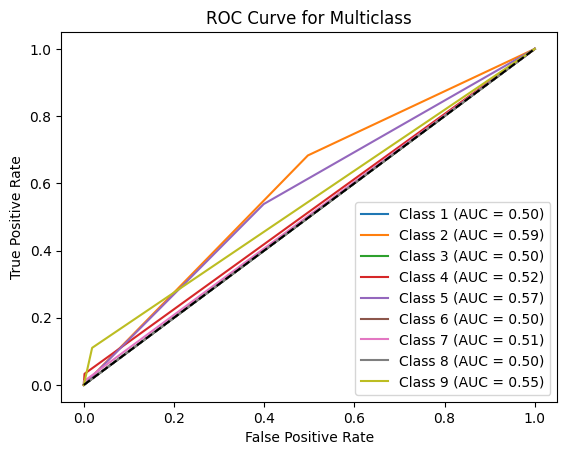

In [256]:
metrics(y_train, y_pred)

Accuracy: 0.4023622047244094
Precision: 0.4023622047244094
Recall: 0.4023622047244094
F1 score: 0.4023622047244094


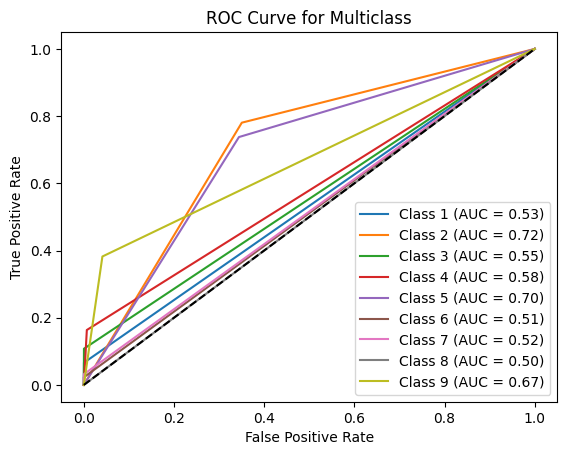

In [257]:
rfc = RFC(n_estimators=100, max_depth=8, min_samples_split=10)
rfc.fit(aggregated_df, y_train)
y_pred = rfc.predict(aggregated_df)
metrics(y_train, y_pred)

Accuracy: 0.958005249343832
Precision: 0.958005249343832
Recall: 0.958005249343832
F1 score: 0.958005249343832


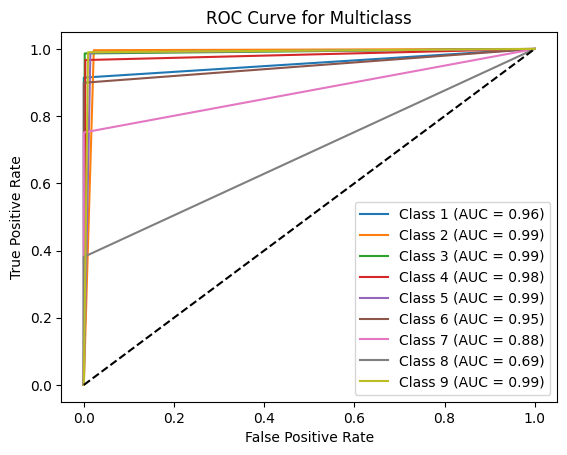

In [258]:
rfc = RFC(n_estimators=200, max_depth=100, min_samples_split=10)
rfc.fit(aggregated_df, y_train)
y_pred = rfc.predict(aggregated_df)
metrics(y_train, y_pred)

Accuracy: 0.9566929133858267
Precision: 0.9566929133858267
Recall: 0.9566929133858267
F1 score: 0.9566929133858267


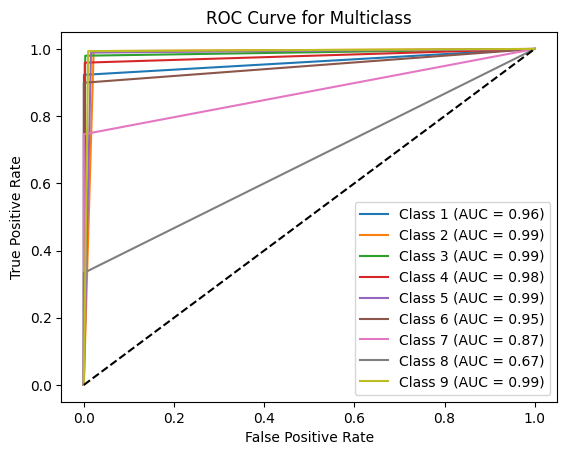

In [259]:
rfc = RFC(n_estimators=200, max_depth=50, min_samples_split=10)
rfc.fit(aggregated_df, y_train)
y_pred = rfc.predict(aggregated_df)
metrics(y_train, y_pred)

Accuracy: 0.9553805774278216
Precision: 0.9553805774278216
Recall: 0.9553805774278216
F1 score: 0.9553805774278216


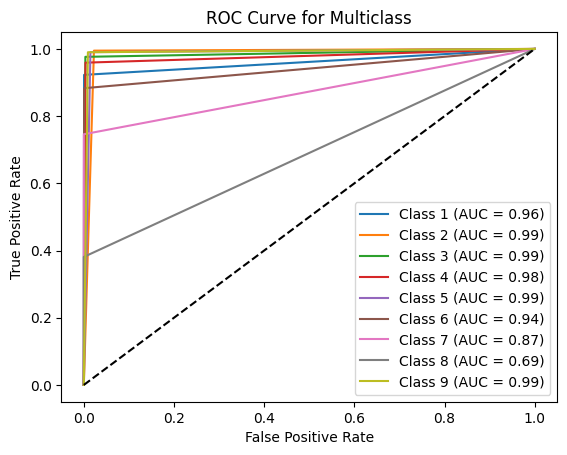

In [260]:
rfc = RFC(n_estimators=150, max_depth=50, min_samples_split=10)
rfc.fit(aggregated_df, y_train)
y_pred = rfc.predict(aggregated_df)
metrics(y_train, y_pred)